In [1]:
#import necessary modules
import matplotlib.pyplot as plt
import numpy as np
from pandas import HDFStore
import os
import sys
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.coordinates import Angle
import csv



In [2]:
#files and folders
folderdir = 'matchfilefolder' #matchfile directory
lcfiledir = 'lcfolder' #insert light curve directory!
#coordinate identifiers. matches input coordinates to matchfile.
sqcoordfile = 'sq_fields.csv' #file location of sq_fields.csv
coordfile = 'fieldcoords.csv' #file location of fieldcoords.csv

In [3]:
#set your RA, DEC, and Threshold radius
ra = 278.858#ra in degrees here
dec = -7.614#dec in degrees here
thresh = 10#thresh in arcsec here
thresh = thresh * u.arcsec

In [4]:
#find fields with specified coordinates within 5 degrees
out = []
with open(coordfile, 'r') as f:
    csvreader = csv.DictReader(f)
    for row in csvreader:
        if abs(ra-float(row['ra'])) <= 5 and abs(dec-float(row['dec'])) <= 5:
            out.append(row['field'])
            print(f"found coordinate in field {row['field']}.")

print(f'found {len(out)} fields with coord')

found coordinate in field 1029.
found coordinate in field 1030.
found coordinate in field 1103.
found coordinate in field 1104.
found 4 fields with coord


In [5]:
#make the lightcurve folder if it does not already exist
if not os.path.exists(lcfiledir):
    os.makedirs(lcfiledir)

In [7]:
#search for coordinate in each subquadrant file
fieldsource = None
quadsource = None
subquadsource = None
sfound = False
with open(sqcoordfile, 'r') as f:
    csvreader = csv.DictReader(f)
    for row in csvreader:
        if row['field'] in out:
            print('searching f %s q %s sq %s for coordinate'%(row['field'], row['quad'], row['subquad']))
            raedge1 = float(row['raedge1'])
            if raedge1 - float(row['raedge2']) > 0:
                raedge1 -= 360
            if ra > float(row['raedge1']) and ra < float(row['raedge2']):
                if dec > float(row['decedge1']) and dec < float(row['decedge2']):
                    print('found coordinate in field%s quad%s subquad%s' % (row['field'], row['quad'], row['subquad']))
                    fieldsource = row['field']
                    quadsource = row['quad']
                    subquadsource = row['subquad']
                    sfound = True
                    break
    if sfound == False:
        print('could not find source coordinate in a subquadrant')

            
            

searching f 1029 q 0 sq 0 for coordinate
searching f 1029 q 0 sq 1 for coordinate
searching f 1029 q 0 sq 2 for coordinate
searching f 1029 q 0 sq 3 for coordinate
searching f 1029 q 1 sq 0 for coordinate
searching f 1029 q 1 sq 1 for coordinate
searching f 1029 q 1 sq 2 for coordinate
searching f 1029 q 1 sq 3 for coordinate
searching f 1029 q 2 sq 0 for coordinate
searching f 1029 q 2 sq 1 for coordinate
searching f 1029 q 2 sq 2 for coordinate
searching f 1029 q 2 sq 3 for coordinate
searching f 1029 q 3 sq 0 for coordinate
searching f 1029 q 3 sq 1 for coordinate
searching f 1029 q 3 sq 2 for coordinate
searching f 1029 q 3 sq 3 for coordinate
searching f 1030 q 0 sq 0 for coordinate
searching f 1030 q 0 sq 1 for coordinate
searching f 1030 q 0 sq 2 for coordinate
found coordinate in field1030 quad0 subquad2


In [8]:
#get matchfile and data for subquadrant
filename = folderdir + 'match_fid%s_q%s_sq%s.h5' % (fieldsource, quadsource, subquadsource)
if not os.path.exists(filename):
    print('could not find matchfile')
    sys.exit(1)

match = HDFStore(filename)

In [9]:
#find the source in the matchfile data within given threshold

radecdata = (match['sources']['tmcra'], match['sources']['tmcdec'])

datasky = SkyCoord(ra=radecdata[0], dec=radecdata[1], frame='icrs', unit='degree')
sourcecoord = SkyCoord(ra=[ra], dec=[dec], frame='icrs', unit='degree')
idsource, iddata, d2d, d3d = datasky.search_around_sky(sourcecoord, thresh)
if len(iddata) == 0:
    realid = 0
    print('could not find coordinate in data')
if len(iddata) >= 1:
    minangle = Angle('10d')
    realid = None
    for i in iddata:
        datacoord  = SkyCoord(ra=[radecdata[0][i]], dec=[radecdata[1][i]], frame='icrs', unit='degree')
        sep = sourcecoord.separation(datacoord)
        if sep < minangle:
            minangle = sep
            realid = i


In [10]:
#read matchfile for relevant information

sourceid = match['sources']['pts_key'][realid]

sourcedatarow = np.where(match['sourcedata']['pts_key'] == sourceid)[0] #find the rows for this source in sourcedata table

sourcera = match['sources']['tmcra'][realid]

sourcedec = match['sources']['tmcdec'][realid]

jds = match['sourcedata']['obsjd'][sourcedatarow] - 2458000 

mags = match['sourcedata']['magpsf'][sourcedatarow]

magerrs = match['sourcedata']['magpsferr'][sourcedatarow]

staterrs = match['sourcedata']['magpsfstaterr'][sourcedatarow]

flags = match['sourcedata']['flags'][sourcedatarow]

sourceinfo = {'mags':mags, 'magerrs':magerrs, 'staterrs':staterrs, 'flags':flags, 'jds':jds, 'ra':sourcera, 'dec':sourcedec, 'id':sourceid}

#close matchfile
match.close()

In [16]:
#Read the quality flags for each epoch. Uncomment flags you wish to apply to your data.
procflags = []
for flagval in flags:
    totflag = False
    if flagval - 32 >= 0:
        #totflag = True #uncomment to get rid of measurements with aperture contamination (F6).
        flagval -= 32
    if flagval - 16 >= 0:
        #totflag = True #uncomment to get rid of measurements with zero point deviation (F5).
        flagval -= 16
    if flagval - 8 >= 0:
        #totflag = True #uncomment to get rid of measurements with bad airmass (F4).
        flagval -= 8
    if flagval - 4 >= 0:
        #totflag = True #uncomment to get rid of measurements with magnitudes outside of that is recommended (F3).
        flagval -= 4
    if flagval - 2 >= 0:
        #totflag = True #uncomment to get rid of measurements with pixel saturation (F2).
        flagval -= 2
    if flagval - 1 >= 0:
        #totflag = True #uncomment to get rid of measurements on the west meridian side (F1).
        flagval -= 1
    procflags.append(totflag)

In [17]:
#remove all flagged measurements
mag = [list(sourceinfo['mags'])[ind] for ind in range(len(procflags)) if procflags[ind] == False]
jd = [list(sourceinfo['jds'])[ind] for ind in range(len(procflags)) if procflags[ind] == False]
magerr = [list(sourceinfo['magerrs'])[ind] for ind in range(len(procflags)) if procflags[ind] == False]
staterr = [list(sourceinfo['staterrs'])[ind] for ind in range(len(procflags)) if procflags[ind] == False]
badmag = [list(sourceinfo['mags'])[ind] for ind in range(len(procflags)) if procflags[ind] == True]
badjd = [list(sourceinfo['jds'])[ind] for ind in range(len(procflags)) if procflags[ind] == True]
badmagerr = [list(sourceinfo['magerrs'])[ind] for ind in range(len(procflags)) if procflags[ind] == True]
badstaterr = [list(sourceinfo['staterrs'])[ind] for ind in range(len(procflags)) if procflags[ind] == True]

#get the rest of relevant information
sourceid = sourceinfo['id']
racat = sourceinfo['ra']
deccat = sourceinfo['dec']


created lc file for ra278.858 dec-7.614, file /Users/shionmurakawa/Desktop/PGIR_files/lightcurve_fid1030_q0_sq2_id501326289.pdf


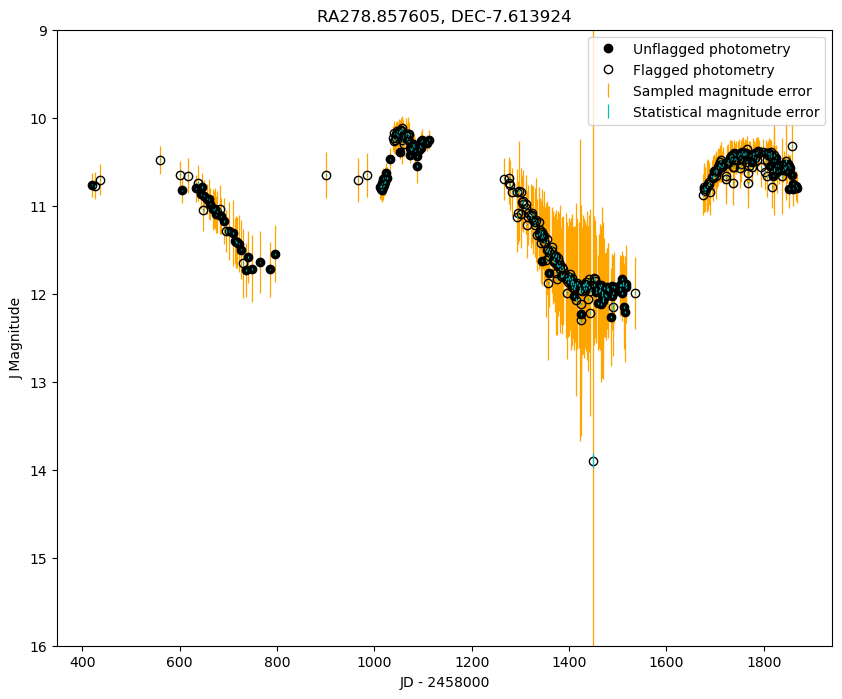

In [33]:
#name light curve file
lcfilename = lcfiledir + 'lightcurve_fid%s_q%s_sq%s_id%d.pdf'%(fieldsource, quadsource, subquadsource, sourceid)

#plot and save figure
plt.figure(figsize=(10,8))

#choose between plotting with the PSF error or statistical error of measurement
plt.errorbar(jd, mag, fmt='o', color='k', ms=6, ls='', zorder=10, label='Unflagged photometry')
plt.errorbar(badjd, badmag, fmt='o', markeredgecolor='k', markerfacecolor='none', ms=6, ls='', zorder=10, label='Flagged photometry')
plt.errorbar(jd, mag, yerr=magerr, fmt=',', elinewidth=0.9, ms=6, ecolor='orange', zorder=0, label='Sampled magnitude error')
plt.errorbar(badjd, badmag, yerr=badmagerr, fmt=',', elinewidth=0.9, ms=6, ecolor='orange', zorder=0)
plt.errorbar(jd, mag, yerr=staterr, color='none', fmt=',', elinewidth=0.9, ms=6, ecolor='c', zorder=20, label='Statistical magnitude error')
plt.errorbar(badjd, badmag, yerr=badstaterr, color='none', fmt=',', elinewidth=0.9, ms=6, ecolor='c', zorder=20)

plt.xlabel('JD - 2458000')
plt.ylabel('J Magnitude')
plt.title('RA%.6f, DEC%.6f' % (float(racat), float(deccat)))
plt.gca().invert_yaxis()
plt.legend()
plt.savefig(lcfilename)
print('created lc file for ra%.3f dec%.3f, file %s' % (ra, dec, lcfilename))
plt.show()